In [1]:
from pathlib import Path
BASE_DIR = Path().resolve()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#   ..................... MANEJO DEL DATASET .................................
class PlacaDataset(Dataset):
    def __init__(self, X_path, Y_path, mean_X=None, std_X=None, mean_Y=None, std_Y=None):
        self.X = np.load(X_path).astype(np.float32)
        self.Y = np.load(Y_path).astype(np.float32)

        # ---------------- StandardScaler en X ----------------
        if mean_X is None:
            self.mean_X = self.X.mean(axis=0)
            self.std_X = self.X.std(axis=0)
        else:
            self.mean_X = mean_X
            self.std_X = std_X

        self.std_X[self.std_X == 0] = 1.0  # Evitar división por cero
        self.X = (self.X - self.mean_X) / self.std_X

        # ---------------- StandardScaler en Y ----------------
        if mean_Y is None:
            self.mean_Y = self.Y.mean()
            self.std_Y = self.Y.std()
        else:
            self.mean_Y = mean_Y
            self.std_Y = std_Y

        if self.std_Y == 0:
            self.std_Y = 1.0

        self.Y = (self.Y - self.mean_Y) / self.std_Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


#   .................... DEFINIDION DEL MODELO ................................

class MLPTempRegressor(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(

            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),

        )

    def forward(self, x):
        return self.model(x)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')#  (Para un posible uso de GPU)

#   .................... CONFIGURACION ...............................................
#   Rutas de archivos 

X_path = BASE_DIR.parent / 'data' / 'dataset_5000_test' / 'X.npy'
Y_path = BASE_DIR.parent / 'data' / 'dataset_5000_test' / 'Y.npy'

dataset = PlacaDataset(X_path, Y_path)

batch_size = 16 #   Esta es la cantidad de muestras por lote 

#   Se toma 16 muestras del dataset y se las mezlca

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#   Es la cantidad de entradas y salidas del dataset

input_dim = dataset.X.shape[1]
output_dim = dataset.Y.shape[1]

#   Se inicializa el modelo

model = MLPTempRegressor(input_dim, output_dim).to(device)

#..................... DEFINICION DE LA FUNCION DE PERDIDA ..................

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 1000

#............................................................................

#...................... ENTRENAMIENTO ........................................

#   Funcion donde se guarda el historial de perdidas 

loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    loss_history.append(avg_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
        # Monitoreo de outputs
        with torch.no_grad():
            test_output = model(torch.tensor(dataset.X[:3]).to(device)).cpu().numpy()
            print(f"Sample outputs at epoch {epoch}: {test_output[:, :5]}")

print("Entrenamiento finalizado.")

# Guardado de modelo y parámetros de normalización
model_save_path = BASE_DIR.parent / 'results' / 'modelo_temp_ML_std2.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado en {model_save_path}")

np.save(BASE_DIR.parent / 'results' / 'mean_X.npy', dataset.mean_X)
np.save(BASE_DIR.parent / 'results' / 'std_X.npy', dataset.std_X)
np.save(BASE_DIR.parent / 'results' / 'mean_Y.npy', dataset.mean_Y)
np.save(BASE_DIR.parent / 'results' / 'std_Y.npy', dataset.std_Y)

Epoch 0, Loss: 0.832831
Sample outputs at epoch 0: [[-0.33036458 -0.35185295 -0.26686847 -0.24186465 -0.2814169 ]
 [ 0.38853264  0.41921294  0.3589601   0.36792985  0.3886405 ]
 [ 1.4358457   1.340488    1.2799549   1.3529255   1.3740201 ]]
Epoch 50, Loss: 0.074333
Sample outputs at epoch 50: [[0.58012533 0.6809345  0.71072245 0.7169806  0.6926968 ]
 [0.46668673 0.19301723 0.16790506 0.1745938  0.11644369]
 [1.1522373  1.5516468  1.5482562  1.6052506  1.644306  ]]
Epoch 100, Loss: 0.021836
Sample outputs at epoch 100: [[ 0.50028896  0.6027052   0.6134362   0.61319643  0.6062987 ]
 [ 0.39442733 -0.5911905  -0.6195288  -0.6278639  -0.6851933 ]
 [ 0.36223894  1.0615788   1.1381732   1.2227231   1.2946941 ]]
Epoch 150, Loss: 0.012401
Sample outputs at epoch 150: [[ 0.6856417   0.7744349   0.7683712   0.771937    0.78838396]
 [ 0.4173445  -0.84593016 -0.8633368  -0.8659093  -0.9119801 ]
 [ 0.22925186  1.0093395   1.1135018   1.1932168   1.273449  ]]
Epoch 200, Loss: 0.009584
Sample outputs 

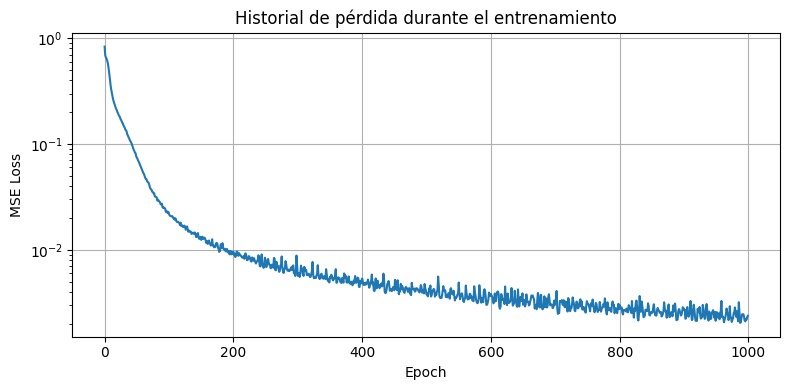

In [24]:
# Graficar pérdida
plt.figure(figsize=(8, 4))
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Historial de pérdida durante el entrenamiento")
plt.grid(True)
plt.tight_layout()
plt.show()

Modelo cargado correctamente.
Y_pred min: 394.42 °C
Y_pred max: 1464.57 °C
Y_pred mean: 973.39 °C
Y_true min: 413.68478
Y_true max: 1443.936
Y_true mean: 970.927
Comparación de distribuciones:
Diferencia máxima: 475.6213 °C
Diferencia media:  14.7605 °C
Desvío estándar:   17.2084 °C


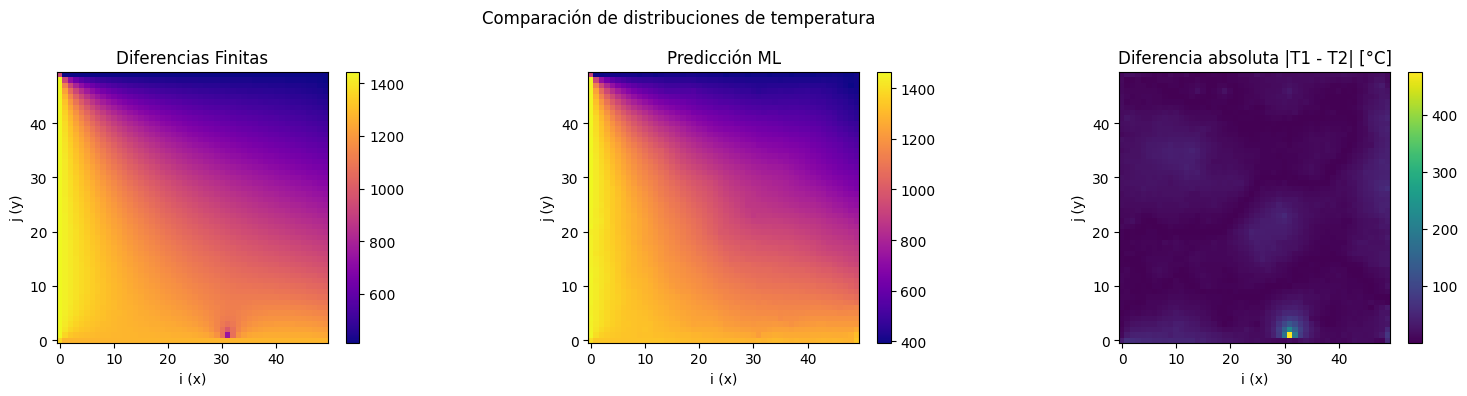

In [30]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from utils import graficarChapa, comparar_T

BASE_DIR = Path().resolve()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_path = BASE_DIR.parent / 'data' / 'dataset_5000_test' / 'X.npy'
Y_path = BASE_DIR.parent / 'data' / 'dataset_5000_test' / 'Y.npy'

mean_X = np.load(BASE_DIR.parent / 'results' / 'mean_X.npy')
std_X = np.load(BASE_DIR.parent / 'results' / 'std_X.npy')
mean_Y = np.load(BASE_DIR.parent / 'results' / 'mean_Y.npy').item()
std_Y = np.load(BASE_DIR.parent / 'results' / 'std_Y.npy').item()

X_data = np.load(X_path).astype(np.float32)
Y_data = np.load(Y_path).astype(np.float32)

# Normalización de X para inferencia
X_data_norm = (X_data - mean_X) / std_X

input_dim = X_data.shape[1]
output_dim = Y_data.shape[1]

model = MLPTempRegressor(input_dim, output_dim).to(device)
model_save_path = BASE_DIR.parent / 'results' / 'modelo_temp_ML_std2.pt'
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()
print("Modelo cargado correctamente.")

idx_muestra = 1000

X_sample_tensor = torch.tensor(X_data_norm[idx_muestra]).unsqueeze(0).to(device)
Y_pred_norm = model(X_sample_tensor).detach().cpu().numpy().squeeze()

# Desnormalización
Y_pred = Y_pred_norm * std_Y + mean_Y

print(f"Y_pred min: {Y_pred.min():.2f} °C")
print(f"Y_pred max: {Y_pred.max():.2f} °C")
print(f"Y_pred mean: {Y_pred.mean():.2f} °C")

Y_pred_img = Y_pred.reshape(50, 50)
Y_true_img = Y_data[idx_muestra].reshape(50, 50)

print("Y_true min:", Y_true_img.min())
print("Y_true max:", Y_true_img.max())
print("Y_true mean:", Y_true_img.mean())

comparar_T(Y_true_img, Y_pred_img, 50, 50, etiquetas=('Diferencias Finitas', 'Predicción ML'))
